In [1]:
#%%
print('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting')

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting


In [2]:
def data_prep(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']

    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(variants['sample_id'].unique()):
        aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

    return aa_array, mic_aa

def data_split(aa_array, encoded_mic):
    # Encode the target variable
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

In [3]:
def data_prep_(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
            
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # print(mic_aa.shape)
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # print(mic_aa.shape)

    return aa_array, mic_aa

In [4]:

df = pd.read_csv('../CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]

# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[df_emb['ENA_RUN'].isin(samples)]
cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = mic_aa['EMB_MIC'].to_list()

# train_data, test_data, train_target, test_target = data_split(aa_array, encoded_mic)

mic_series = np.log2(mic_aa['EMB_MIC'])
mic_series += 1
sample_ids = mic_aa['ENA_RUN']

mic_series_bi = mic_aa['EMB_MIC'].apply(lambda x: 1 if x >= 4 else 0)
mic_series_all = pd.merge(mic_series, mic_series_bi, left_index=True, right_index=True)
train_data, test_data, train_target, test_target = data_split(aa_array, mic_series_all)
target_min, target_max = mic_series.min(), mic_series.max()


/tmp/ipykernel_99372/3889690407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_99372/3889690407.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|██████████| 11362/11362 [01:01<00:00, 183.55it/s]
/tmp/ipykernel_99372/619452980.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [7]:
variants = pd.read_csv('../variants_full.csv')
variants = variants[variants['gene'] != 'PPE35']
variants = variants[variants['type'] != 'synonymous_variant']
variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
# variants = variants[variants['drugs'].isin(['ethambutol'])]
variants = variants[variants['gene'].isin(gene_list)]
variants = variants[variants['sample_id'].isin(overlap)]
variants['SNP'] = variants['gene'] + '-'+ variants['change']
# print(variants.shape)

In [13]:
type(variants['SNP'].unique())

numpy.ndarray

In [14]:
with open('crypticSNPnames.npy', 'wb') as f:
    np.save(f, variants['SNP'].unique())


In [15]:
crypticSNPnames = np.load('crypticSNPnames.npy', allow_pickle=True)

In [17]:
len(crypticSNPnames)

1710

In [6]:
train_data.shape

(10225, 1710)

## cornloss weighting

In [6]:
train_target_counts = torch.from_numpy(train_target.values).flatten()
# train_target_counts = torch.tensor([0,1,2])


In [7]:
# import torch
# import torch.nn.functional as F

# def compute_class_weights(y_train, num_classes):
#     class_counts = torch.bincount(y_train, minlength=num_classes)
#     print(class_counts)
#     class_weights = 1.0 / class_counts.float()
#     class_weights = class_weights / class_weights.sum() * num_classes  # Normalize weights
#     return class_weights

# # Example usage
# num_classes = 3
# class_weights = compute_class_weights(train_target_counts, num_classes)
# print(class_weights)

In [8]:
# def loss_corn(logits, y_train, num_classes, class_weights):
#     sets = []
#     for i in range(num_classes - 1):
#         label_mask = y_train > i - 1
#         label_tensor = (y_train[label_mask] > i).to(torch.int64)
#         sets.append((label_mask, label_tensor))

#     num_examples = 0
#     losses = 0.
#     for task_index, s in enumerate(sets):
#         train_examples = s[0]
#         train_labels = s[1]

#         if len(train_labels) < 1:
#             continue

#         num_examples += len(train_labels)
#         pred = logits[train_examples, task_index]

#         # Apply class weights
#         weights = class_weights[train_labels].to(logits.device)
        
#         loss = -torch.sum(weights * (F.logsigmoid(pred) * train_labels +
#                                      (F.logsigmoid(pred) - pred) * (1 - train_labels)))
#         losses += loss
#     return losses / num_examples

# # Example usage
# # logits = torch.randn(9, 2).cuda()  # Example logits tensor
# # y_train = torch.tensor([0, 1, 2, 0, 1, 2, 2, 1, 0]).cuda()  # Example training labels
# # class_weights = compute_class_weights(y_train.cpu(), num_classes).cuda()

# # loss = loss_corn(logits, y_train, num_classes, class_weights)
# # print(f"Loss: {loss.item()}")


## Dataset

In [81]:
from torch.utils.data import Subset
from collections import Counter

N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)
#%%
def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )


class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        index = int(index)
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            mic = self.res_df.iloc[index, 0]
            res = self.res_df.iloc[index, 1]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            mic = self.res_df.iloc[index, 0]
            res = self.res_df.iloc[index, 1]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0),  torch.tensor(mic).long().flatten().squeeze(), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
# train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

train_idx, validation_idx = train_test_split(np.arange(len(train_data)),
                                             test_size=0.1,
                                             random_state=42,
                                             shuffle=True,
                                             stratify=train_target)

# Subset dataset for train and val
train_dataset = Subset(training_dataset, train_idx)
val_dataset = Subset(training_dataset, validation_idx)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn_mic = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC_x'])
weighted_cross_entropy_loss_fn_bi = get_weighted_masked_cross_entropy_loss(column_weight_maps['EMB_MIC_y'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss, optimizer, model):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f"#>> {appendix}, Epoch: {epoch}, LR: {lr}, fcDR: {fcdr}\n")
        f.write(f"Train_Loss= {train_loss}\n")
        f.write(f"Test_Loss= {test_loss}\n")
        f.write(f"lossGraph(Train_Loss, Test_Loss, '{appendix}-Epoch-{epoch}-LR-{lr}-fcDR-{fcdr}')\n")

    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

 


## Model

In [133]:
       
from torch.optim.lr_scheduler import CyclicLR

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [53568]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        # self.dense_layers = nn.ModuleList(
            # self._dense_layer(input_dim, num_dense_neurons)
            # for input_dim in [current_num_filters2]
            # + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) 
        )
        
        self.prediction_layer_bi = (
            nn.Linear(num_dense_neurons, 2)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, 2), nn.ReLU()) 
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        x_mic = self.prediction_layer(x)
        x_bi = self.prediction_layer_bi(x)
        
        return x_mic, x_bi

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

In [11]:
model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
# conv_dropout_rate=conv_dropout_rate,
# dense_dropout_rate=dense_dropout_rate
).to(device)


In [50]:
batch_size = 64
# lr = 0.0085
# lr = 0.00002


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

## Single run

 50%|█████     | 50/100 [04:33<04:33,  5.48s/it]

Epoch 50
Training loss: 0.24973687529563904
Validation loss: 0.32646477222442627


100%|██████████| 100/100 [09:07<00:00,  5.47s/it]

Epoch 100
Training loss: 0.24117718636989594
Validation loss: 0.3413775861263275


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb


/tmp/ipykernel_19835/641108661.py:179: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Sensitivity: 0.8373493975903614
Specificity: 0.924223602484472
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Learning rate: 0.0001
Weight decay: 0.0001
Accuracy: 0.8988566402814424
Mae: 0.1011433597185576
F1 Score: 0.8991633766628379
conf_matrix: [[744  61]
 [ 54 278]]
Doubling Dilution Accuracy: 0.8795074758135444
AUC: 0.8300683919304397
Sensitivity: 0.7377049180327869
Specificity: 0.9224318658280922


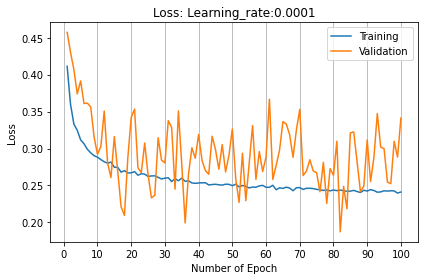

In [142]:
#input parameter
lr = 1e-4
epoch = 100
conv_dropout_rate=0.4
dense_dropout_rate=0.5
weight_decay=1e-4

######################################

model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

# batch_size = 64
batch_size_train = 32
batch_size_val = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size_val, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion_mic = weighted_cross_entropy_loss_fn_mic
criterion_bi = weighted_cross_entropy_loss_fn_bi
# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train_mic, y_train_bi in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch_mic = y_train_mic.to(device)
        y_batch_bi = y_train_bi.to(device)
        
        x_batch = x_batch.float()
        pred_mic, pred_bi = model(x_batch.float())

        # break
        # loss_train = loss_corn(pred, y_batch, 3, class_weights)
        loss_train_mic = criterion_mic(pred_mic,y_batch_mic)
        loss_train_bi = criterion_bi(pred_bi,y_batch_bi)
        loss_train = loss_train_mic + loss_train_bi
        # print(pred)
        # print(y_batch)
        # print(loss_train)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate
        # break
    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test_mic, y_test_bi in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch_mic = y_test_mic.to(device)
            y_batch_bi = y_test_bi.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
        pred_mic, pred_bi = model(x_batch.float())

        # break
        # loss_train = loss_corn(pred, y_batch, 3, class_weights)
        loss_test_mic = criterion_mic(pred_mic,y_batch_mic)
        loss_test_bi = criterion_bi(pred_bi,y_batch_bi)
        loss_test = loss_test_mic + loss_test_bi
        
            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            # loss_test = loss_corn(pred, y_batch, 3, class_weights)
        test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if e%50 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping

print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

# #%%

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_mic_list = []
pred_bi_list = []
target_mic_list  = []
target_bi_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test_mic, y_test_bi in testing_loader1:
        xtest1 = x_test.to(device).float()
        # ytest1_mic = y_test_mic.to(device).float()
        # ytest1_bi = y_test_bi.to(device).float()
        pred_mic, pred_bi = model(xtest1)
        pred_mic_list.append(np.argmax(pred_mic.detach().cpu().numpy())) 
        pred_bi_list.append(np.argmax(pred_bi.detach().cpu().numpy())) 
        target_mic_list.append(y_test_mic.detach().cpu().numpy())
        target_bi_list.append(y_test_bi.detach().cpu().numpy())
target_list = np.array(target_list).flatten()

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_bi_list, pred_bi_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_mic_list, target_mic_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate AUC
cutoff = 4
test_target_bi = (np.squeeze(np.array(target_mic_list)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(pred_mic_list)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

In [94]:

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_mic_list = []
pred_bi_list = []
target_mic_list  = []
target_bi_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test_mic, y_test_bi in testing_loader1:
        xtest1 = x_test.to(device).float()
        # ytest1_mic = y_test_mic.to(device).float()
        # ytest1_bi = y_test_bi.to(device).float()
        pred_mic, pred_bi = model(xtest1)
        pred_mic_list.append(np.argmax(pred_mic.detach().cpu().numpy())) 
        pred_bi_list.append(np.argmax(pred_bi.detach().cpu().numpy())) 
        target_mic_list.append(y_test_mic.detach().cpu().numpy())
        target_bi_list.append(y_test_bi.detach().cpu().numpy())
target_list = np.array(target_list).flatten()

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_bi_list, pred_bi_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_mic_list, target_mic_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

# Calculate AUC
cutoff = 4
test_target_bi = (np.squeeze(np.array(target_mic_list)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(pred_mic_list)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Sensitivity: 0.8343373493975904
Specificity: 0.9316770186335404
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Learning rate: 0.0001
Weight decay: 0.0001
Accuracy: 0.9032541776605101
Mae: 0.09674582233948989
F1 Score: 0.9032541776605101
conf_matrix: [[750  55]
 [ 55 277]]
Doubling Dilution Accuracy: 0.8707124010554089
AUC: 0.8278602605079562
Sensitivity: 0.73224043715847
Specificity: 0.9234800838574424


In [93]:
(np.squeeze(np.array(target_mic_list)) >= cutoff).astype(int)

array([1, 0, 0, ..., 0, 0, 0])

In [86]:
tn, fp, fn, tp = confusion_matrix(test_bi_target, test_bi_predictions).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

NameError: name 'test_bi_target' is not defined

In [46]:

# Calculate AUC
cutoff = 4
test_target_bi = (target_list >= cutoff).astype(int)
test_predictions_bi = (np.array(pred_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

AUC: 0.7999020517579132
Sensitivity: 0.6721311475409836
Specificity: 0.9276729559748428


## Hypterparameter tuning

***New input parameter***


 10%|█         | 50/500 [04:18<38:26,  5.12s/it]

Epoch 50
Training loss: 0.22124092280864716
Validation loss: 0.2778877019882202


 20%|██        | 100/500 [08:40<34:40,  5.20s/it]

Epoch 100
Training loss: 0.2171449512243271
Validation loss: 0.2902788817882538


 30%|███       | 150/500 [13:00<30:10,  5.17s/it]

Epoch 150
Training loss: 0.2155919075012207
Validation loss: 0.3066912293434143


 40%|████      | 200/500 [17:20<26:08,  5.23s/it]

Epoch 200
Training loss: 0.21383823454380035
Validation loss: 0.3269326090812683


 50%|█████     | 250/500 [21:40<21:29,  5.16s/it]

Epoch 250
Training loss: 0.2127774953842163
Validation loss: 0.40956413745880127


 60%|██████    | 300/500 [26:00<17:16,  5.18s/it]

Epoch 300
Training loss: 0.2140410840511322
Validation loss: 0.2912551760673523


 70%|███████   | 350/500 [30:21<13:00,  5.20s/it]

Epoch 350
Training loss: 0.21151919662952423
Validation loss: 0.3021072745323181


 80%|████████  | 400/500 [34:41<08:38,  5.19s/it]

Epoch 400
Training loss: 0.21183183789253235
Validation loss: 0.44840553402900696


 90%|█████████ | 450/500 [39:01<04:20,  5.22s/it]

Epoch 450
Training loss: 0.21025371551513672
Validation loss: 0.36331382393836975


100%|██████████| 500/500 [43:22<00:00,  5.20s/it]

Epoch 500
Training loss: 0.21062009036540985
Validation loss: 0.34585094451904297


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_0.0001_weighted_balanced.png-emb


/tmp/ipykernel_19835/1775929221.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Sensitivity: 0.8343373493975904
Specificity: 0.924223602484472
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Learning rate: 0.0001
Weight decay: 0
Accuracy: 0.8979771328056289
Mae: 0.10202286719437115
F1 Score: 0.8982431357775635
conf_matrix: [[744  61]
 [ 55 277]]
** EA terms:
Doubling Dilution Accuracy: 0.8751099384344767
AUC: 0.8170429941231055
Sensitivity: 0.7158469945355191
Specificity: 0.9182389937106918
***New input parameter***


 10%|█         | 50/500 [04:19<38:57,  5.19s/it]

Epoch 50
Training loss: 0.225474551320076
Validation loss: 0.31923040747642517


 20%|██        | 100/500 [08:40<34:44,  5.21s/it]

Epoch 100
Training loss: 0.2205703854560852
Validation loss: 0.30074039101600647


 30%|███       | 150/500 [13:00<30:36,  5.25s/it]

Epoch 150
Training loss: 0.21928194165229797
Validation loss: 0.2909793257713318


 40%|████      | 200/500 [17:21<26:05,  5.22s/it]

Epoch 200
Training loss: 0.21676792204380035
Validation loss: 0.269696444272995


 50%|█████     | 250/500 [21:41<21:41,  5.21s/it]

Epoch 250
Training loss: 0.2163211703300476
Validation loss: 0.2908167541027069


 60%|██████    | 300/500 [26:01<17:16,  5.18s/it]

Epoch 300
Training loss: 0.2158873826265335
Validation loss: 0.31545063853263855


 70%|███████   | 350/500 [30:22<13:07,  5.25s/it]

Epoch 350
Training loss: 0.2156008630990982
Validation loss: 0.2863151431083679


 80%|████████  | 400/500 [34:43<08:41,  5.21s/it]

Epoch 400
Training loss: 0.21520856022834778
Validation loss: 0.34314748644828796


 90%|█████████ | 450/500 [39:03<04:19,  5.19s/it]

Epoch 450
Training loss: 0.2138487547636032
Validation loss: 0.2831560969352722


100%|██████████| 500/500 [43:24<00:00,  5.21s/it]

Epoch 500
Training loss: 0.21394972503185272
Validation loss: 0.3068199157714844


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-05_weighted_balanced.png-emb


/tmp/ipykernel_19835/1775929221.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Sensitivity: 0.8343373493975904
Specificity: 0.929192546583851
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-05
Weight decay: 0
Accuracy: 0.9014951627088831
Mae: 0.09850483729111698
F1 Score: 0.9015818086428096
conf_matrix: [[748  57]
 [ 55 277]]
** EA terms:
Doubling Dilution Accuracy: 0.8671943711521548
AUC: 0.8170429941231055
Sensitivity: 0.7158469945355191
Specificity: 0.9182389937106918
***New input parameter***


 10%|█         | 50/500 [04:19<38:01,  5.07s/it]

Epoch 50
Training loss: 0.2384909987449646
Validation loss: 0.24968251585960388


 20%|██        | 100/500 [08:33<33:54,  5.09s/it]

Epoch 100
Training loss: 0.22969645261764526
Validation loss: 0.2770164906978607


 30%|███       | 150/500 [12:47<29:23,  5.04s/it]

Epoch 150
Training loss: 0.22436071932315826
Validation loss: 0.32608240842819214


 40%|████      | 200/500 [16:59<25:21,  5.07s/it]

Epoch 200
Training loss: 0.22320722043514252
Validation loss: 0.27083367109298706


 50%|█████     | 250/500 [21:14<21:12,  5.09s/it]

Epoch 250
Training loss: 0.22276906669139862
Validation loss: 0.35143014788627625


 60%|██████    | 300/500 [25:28<16:51,  5.06s/it]

Epoch 300
Training loss: 0.22079844772815704
Validation loss: 0.2888466715812683


 70%|███████   | 350/500 [29:42<12:41,  5.08s/it]

Epoch 350
Training loss: 0.22048144042491913
Validation loss: 0.2986266016960144


 80%|████████  | 400/500 [33:59<08:43,  5.23s/it]

Epoch 400
Training loss: 0.21877998113632202
Validation loss: 0.2688111960887909


 90%|█████████ | 450/500 [38:18<04:19,  5.19s/it]

Epoch 450
Training loss: 0.2191358059644699
Validation loss: 0.28782498836517334


100%|██████████| 500/500 [42:38<00:00,  5.12s/it]

Epoch 500
Training loss: 0.21934622526168823
Validation loss: 0.23169423639774323


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-06_weighted_balanced.png-emb


/tmp/ipykernel_19835/1775929221.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Sensitivity: 0.8343373493975904
Specificity: 0.9304347826086956
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-06
Weight decay: 0
Accuracy: 0.9023746701846965
Mae: 0.09762532981530343
F1 Score: 0.9024177354198846
conf_matrix: [[749  56]
 [ 55 277]]
** EA terms:
Doubling Dilution Accuracy: 0.8751099384344767
AUC: 0.8080987730693885
Sensitivity: 0.6885245901639344
Specificity: 0.9276729559748428
***New input parameter***


 10%|█         | 50/500 [04:19<38:45,  5.17s/it]

Epoch 50
Training loss: 0.3396523594856262
Validation loss: 0.3774228096008301


 20%|██        | 100/500 [08:40<34:40,  5.20s/it]

Epoch 100
Training loss: 0.30148768424987793
Validation loss: 0.35545259714126587


 30%|███       | 150/500 [12:59<30:18,  5.20s/it]

Epoch 150
Training loss: 0.2850828468799591
Validation loss: 0.32031702995300293


 40%|████      | 200/500 [17:19<25:43,  5.14s/it]

Epoch 200
Training loss: 0.2712593972682953
Validation loss: 0.28594884276390076


 50%|█████     | 250/500 [21:38<21:50,  5.24s/it]

Epoch 250
Training loss: 0.2635475993156433
Validation loss: 0.28520047664642334


 60%|██████    | 300/500 [25:58<17:27,  5.24s/it]

Epoch 300
Training loss: 0.2557242214679718
Validation loss: 0.3094307780265808


 70%|███████   | 350/500 [30:18<12:57,  5.18s/it]

Epoch 350
Training loss: 0.2517944872379303
Validation loss: 0.3498260974884033


 80%|████████  | 400/500 [34:37<08:35,  5.16s/it]

Epoch 400
Training loss: 0.2485324740409851
Validation loss: 0.28956958651542664


 90%|█████████ | 450/500 [38:57<04:20,  5.21s/it]

Epoch 450
Training loss: 0.24489782750606537
Validation loss: 0.2742632031440735


100%|██████████| 500/500 [43:16<00:00,  5.19s/it]

Epoch 500
Training loss: 0.24298664927482605
Validation loss: 0.30981579422950745


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-07_weighted_balanced.png-emb


/tmp/ipykernel_19835/1775929221.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Sensitivity: 0.8403614457831325
Specificity: 0.9130434782608695
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-07
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-07
Weight decay: 0
Accuracy: 0.8918205804749341
Mae: 0.10817941952506596
F1 Score: 0.8925936090057386
conf_matrix: [[735  70]
 [ 53 279]]
** EA terms:
Doubling Dilution Accuracy: 0.8601583113456465
AUC: 0.7986648108052375
Sensitivity: 0.6885245901639344
Specificity: 0.9088050314465409
***New input parameter***


 10%|█         | 50/500 [04:20<38:58,  5.20s/it]

Epoch 50
Training loss: 0.4468096196651459
Validation loss: 0.4443306624889374


 20%|██        | 100/500 [08:40<34:48,  5.22s/it]

Epoch 100
Training loss: 0.38847872614860535
Validation loss: 0.37034088373184204


 30%|███       | 150/500 [13:00<29:56,  5.13s/it]

Epoch 150
Training loss: 0.35412752628326416
Validation loss: 0.3745640516281128


 40%|████      | 200/500 [17:20<26:03,  5.21s/it]

Epoch 200
Training loss: 0.3361438512802124
Validation loss: 0.33571261167526245


 50%|█████     | 250/500 [21:40<21:34,  5.18s/it]

Epoch 250
Training loss: 0.32411301136016846
Validation loss: 0.3320714831352234


 60%|██████    | 300/500 [26:02<17:28,  5.24s/it]

Epoch 300
Training loss: 0.3136327564716339
Validation loss: 0.33140188455581665


 70%|███████   | 350/500 [30:22<13:02,  5.22s/it]

Epoch 350
Training loss: 0.30679193139076233
Validation loss: 0.303510457277298


 80%|████████  | 400/500 [34:43<08:41,  5.22s/it]

Epoch 400
Training loss: 0.30003809928894043
Validation loss: 0.3098509907722473


 90%|█████████ | 450/500 [39:03<04:23,  5.27s/it]

Epoch 450
Training loss: 0.29571670293807983
Validation loss: 0.30799126625061035


100%|██████████| 500/500 [43:24<00:00,  5.21s/it]

Epoch 500
Training loss: 0.29187753796577454
Validation loss: 0.28972625732421875


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-08_weighted_balanced.png-emb


/tmp/ipykernel_19835/1775929221.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Sensitivity: 0.8192771084337349
Specificity: 0.9031055900621118
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 1e-08
    maximize: False
    weight_decay: 0
)
Learning rate: 1e-08
Weight decay: 0
Accuracy: 0.8786279683377308
Mae: 0.12137203166226913
F1 Score: 0.8795435036198176
conf_matrix: [[727  78]
 [ 60 272]]
** EA terms:
Doubling Dilution Accuracy: 0.8689533861037819
AUC: 0.7759820600061862
Sensitivity: 0.6557377049180327
Specificity: 0.8962264150943396


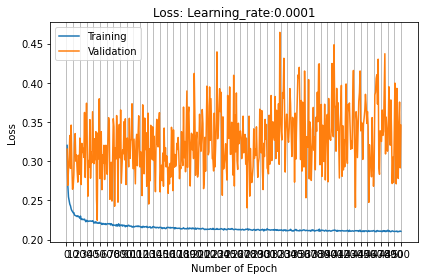

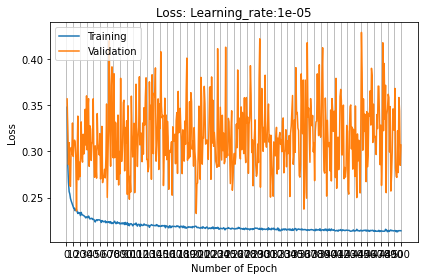

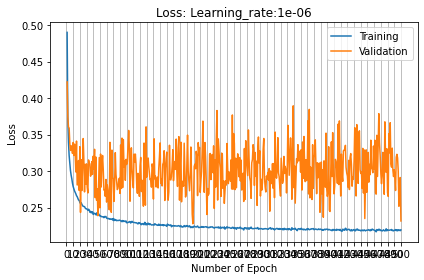

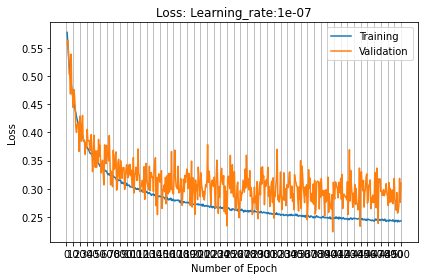

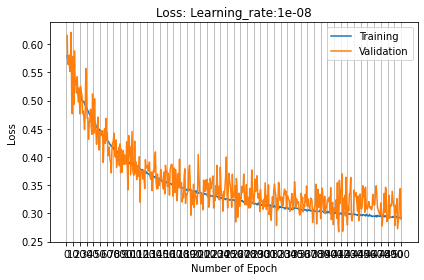

In [141]:
for lr in [1e-4, 1e-5, 1e-6, 1e-7, 1e-8]:
    print('***New input parameter***')
    lr = lr
    epoch = 500
    conv_dropout_rate=0
    dense_dropout_rate=0
    weight_decay=0
    ######################################

    model = Model(
    num_classes=6,
    num_filters=64,
    num_conv_layers=2,
    # num_dense_neurons=256, # batch_size = 64
    num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=conv_dropout_rate,
    dense_dropout_rate=dense_dropout_rate
    ).to(device)


    best_val_loss = float('inf')
    patience = 8  # How many epochs to wait after last time validation loss improved.
    patience_counter = 0
    lmbda = torch.tensor(1e-4, dtype = torch.float32)

    batch_size_train = 32
    batch_size_val = 256
    # lr = 0.0085
    # lr = 0.00002

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True ,num_workers=8, drop_last=True)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size_val, num_workers=8, shuffle=True, drop_last=True)


    criterion_mic = weighted_cross_entropy_loss_fn_mic
    criterion_bi = weighted_cross_entropy_loss_fn_bi

    optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)


    torch.cuda.empty_cache()
    import gc; gc.collect()
    # ic.enable()
    ic.disable()

    train_epoch_loss = []
    test_epoch_loss = []

    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        # print(f'Epoch {e}')
        for x_train, y_train_mic, y_train_bi in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch_mic = y_train_mic.to(device)
            y_batch_bi = y_train_bi.to(device)
            
            x_batch = x_batch.float()
            pred_mic, pred_bi = model(x_batch.float())

            # break
            # loss_train = loss_corn(pred, y_batch, 3, class_weights)
            loss_train_mic = criterion_mic(pred_mic,y_batch_mic)
            loss_train_bi = criterion_bi(pred_bi,y_batch_bi)
            loss_train = loss_train_mic + loss_train_bi
            # print(pred)
            # print(y_batch)
            # print(loss_train)
            train_batch_loss.append(loss_train)        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            # scheduler.step()  # Update the learning rate
            # break
        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        
        pred_mic_list = []
        pred_bi_list = []
        target_mic_list  = []
        target_bi_list  = []
        mse_list = []
        
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x_test, y_test_mic, y_test_bi in test_loader:
                x_batch = torch.squeeze(x_test, 0).to(device)
                x_batch = x_batch.float()
                y_batch_mic = y_test_mic.to(device)
                y_batch_bi = y_test_bi.to(device)
                # print(x_batch.size())
                # y_batch = torch.Tensor.float(y).to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred_mic, pred_bi = model(x_batch.float())   
        
            # pred_mic_list.append(np.argmax(pred_mic.detach().cpu().numpy())) 
            # pred_bi_list.append(np.argmax(pred_bi.detach().cpu().numpy())) 
            # target_mic_list.append(y_test_mic.detach().cpu().numpy())
            # target_bi_list.append(y_test_bi.detach().cpu().numpy())

            # break
            # loss_train = loss_corn(pred, y_batch, 3, class_weights)
            loss_test_mic = criterion_mic(pred_mic,y_batch_mic)
            loss_test_bi = criterion_bi(pred_bi,y_batch_bi)
            loss_test = loss_test_mic + loss_test_bi
            
                # pred = pred.unsqueeze(0)
                # print(pred[:10])
                # print(y_batch[:10])

                # loss_test = loss_corn(pred, y_batch, 3, class_weights)
            test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
        if e%50 == 0:
            print(f'Epoch {e}')
            print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
            print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
        # scheduler.step(torch.mean(torch.stack(test_batch_loss)))


    print('==='*10)
    # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
    save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
                train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

    fig, ax = plt.subplots()
    x = np.arange(1, epoch+1, 1)
    ax.plot(x, train_epoch_loss,label='Training')
    ax.plot(x, test_epoch_loss,label='Validation')
    ax.legend()
    ax.set_xlabel("Number of Epoch")
    ax.set_ylabel("Loss")
    ax.set_xticks(np.arange(0, epoch+1, 10))
    ax.set_title(f'Loss: Learning_rate:{lr}')
    # ax_2 = ax.twinx()
    # ax_2.plot(history["lr"], "k--", lw=1)
    # ax_2.set_yscale("log")
    # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
    ax.grid(axis="x")
    fig.tight_layout()
    fig.show()
    fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
    print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

    # #%%

    #%%
    testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
    testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, num_workers=1, shuffle=True, drop_last=True)

    model.eval()  # For inference

    ic.disable()
    model.eval()
    pred_mic_list = []
    pred_bi_list = []
    target_mic_list  = []
    target_bi_list  = []
    mse_list = []
    with torch.no_grad():
        for x_test, y_test_mic, y_test_bi in testing_loader1:
            xtest1 = x_test.to(device).float()
            # ytest1_mic = y_test_mic.to(device).float()
            # ytest1_bi = y_test_bi.to(device).float()
            pred_mic, pred_bi = model(xtest1)
            pred_mic_list.append(np.argmax(pred_mic.detach().cpu().numpy())) 
            pred_bi_list.append(np.argmax(pred_bi.detach().cpu().numpy())) 
            target_mic_list.append(y_test_mic.detach().cpu().numpy())
            target_bi_list.append(y_test_bi.detach().cpu().numpy())
    target_list = np.array(target_list).flatten()

    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

    def calculate_metrics(true_labels, predictions):
        """
        Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

        Parameters:
        - true_labels: List or array of true labels
        - predictions: List or array of predicted labels

        Returns:
        - accuracy: Overall accuracy of predictions
        - f1: Weighted average F1 score
        - conf_matrix: Multiclass confusion matrix
        - mae: Mean Absolute Error of predictions
        """
        # Ensure inputs are numpy arrays for consistency
        true_labels = np.array(true_labels).squeeze()
        predictions = np.array(predictions).squeeze()

        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)

        # Calculate F1 score
        f1 = f1_score(true_labels, predictions, average='weighted')

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(true_labels, predictions)
        
        if conf_matrix.shape[0] > 2:
            pass
        else:        
            tn, fp, fn, tp = conf_matrix.ravel()
            # Calculate sensitivity (recall)
            sensitivity = tp / (tp + fn)
            print("Sensitivity:", sensitivity)
            # Calculate specificity
            specificity = tn / (tn + fp)
            print("Specificity:", specificity)

        # Calculate MAE
        mae = mean_absolute_error(true_labels, predictions)

        return accuracy, f1, conf_matrix, mae

    accuracy, f1, conf_matrix, mae = calculate_metrics(target_bi_list, pred_bi_list)

    print("======================")
    # print("Model's Named Parameters:")
    # for name, param in model.named_parameters():
    #     print(f"Name: {name}")
    #     print(f"Shape: {param.size()}")
    #     print(f"Requires grad: {param.requires_grad}")
    #     print('-----')
    print("Optimizer details:")
    print(optimizer)
    for param_group in optimizer.param_groups:
        print("Learning rate:", param_group['lr'])
        print("Weight decay:", param_group.get('weight_decay', 'Not set'))
        
    print("======================")
    print(f"Accuracy: {accuracy}")
    print(f"Mae: {mae}")
    print(f"F1 Score: {f1}")
    print(f"conf_matrix: {conf_matrix}")
    print("======================")
    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_mic_list, target_mic_list)])
    
    
    print('** EA terms:')
    print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

    # Calculate AUC
    cutoff = 4
    test_target_bi = (np.squeeze(np.array(target_mic_list)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
    test_predictions_bi = (np.squeeze(np.array(pred_mic_list)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

    auc = roc_auc_score(test_target_bi, test_predictions_bi)
    print("AUC:", auc)

    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

## One cycle lr

 12%|█▎        | 50/400 [02:28<17:21,  2.97s/it]

Epoch 50
Training loss: 0.11537401378154755
Validation loss: 0.14441072940826416


 25%|██▌       | 100/400 [04:58<14:56,  2.99s/it]

Epoch 100
Training loss: 0.11210744082927704
Validation loss: 0.1536770612001419


 38%|███▊      | 150/400 [07:28<12:28,  3.00s/it]

Epoch 150
Training loss: 0.11056072264909744
Validation loss: 0.16507422924041748


 50%|█████     | 200/400 [09:57<09:53,  2.97s/it]

Epoch 200
Training loss: 0.1097438856959343
Validation loss: 0.17116251587867737


 62%|██████▎   | 250/400 [12:32<07:39,  3.06s/it]

Epoch 250
Training loss: 0.10918270796537399
Validation loss: 0.1748015433549881


 75%|███████▌  | 300/400 [15:02<04:53,  2.94s/it]

Epoch 300
Training loss: 0.10868095606565475
Validation loss: 0.17704497277736664


 88%|████████▊ | 350/400 [17:41<02:47,  3.35s/it]

Epoch 350
Training loss: 0.10827459394931793
Validation loss: 0.18684180080890656


100%|██████████| 400/400 [20:27<00:00,  3.07s/it]

Epoch 400
Training loss: 0.10818441957235336
Validation loss: 0.17728930711746216


/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_1e-07_weighted_balanced.png-emb
Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.9499999993756804, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0004
    lr: 4.006243171376002e-08
    max_lr: 0.01
    max_momentum: 0.95
    maximize: False
    min_lr: 4e-08
    weight_decay: 0
)
Learning rate: 4.006243171376002e-08
Weight decay: 0
Accuracy: 0.47568523430592397
Mae: 0.6578249336870027
F1 Score: 0.44584107920478183
conf_matrix: [[ 34  66   7   3   1   1]
 [ 63 285  32   9   5   0]
 [ 40 188  41  19   3   2]
 [  4  20   7  75  42   1]
 [  2   8   0  34  77  16]
 [  0   3   0   5  12  26]]
Doubling Dilution Accuracy: 0.8992042440318302


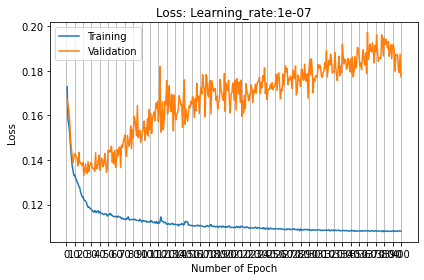

In [22]:
#input parameter
lr = 1e-7
epoch = 400
conv_dropout_rate=0
dense_dropout_rate=0
# weight_decay=1e-8
weight_decay=0


best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr
######################################

model = Model(
num_classes=6,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

criterion = weighted_cross_entropy_loss_fn
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=epoch)
# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping




# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn


# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = criterion(pred,y_batch)

        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = criterion(pred,y_batch)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())
    if e % 50 == 0:
        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

## Cyclical lr

In [ ]:
#input parameter
lr = 1e-7
epoch = 250
conv_dropout_rate=0.05
dense_dropout_rate=0.5
weight_decay=1e-8

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-9, max_lr=0.001)
######################################

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
# num_dense_neurons=256, # batch_size = 64
num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=conv_dropout_rate,
dense_dropout_rate=dense_dropout_rate
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = lr

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
# criterion = weighted_cross_entropy_loss_fn
# criterion = masked_MAE
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo
#%%

torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())

        # break
        loss_train = criterion(pred,y_batch)

        train_batch_loss.append(loss_train)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())
            loss_test = loss_corn(pred, y_batch, 3, class_weights)

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_ce-binned-EMB_newdata_corn' ,epoch, lr=lr, fcdr=dense_dropout_rate, l2=weight_decay, cnndr=conv_dropout_rate, 
             train_loss = train_epoch_loss, test_loss = test_epoch_loss, optimizer=optimizer, model = model)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced-emb.png')
print(f'/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/graphs3/aa-loss_lr_{lr}_weighted_balanced.png-emb')

#%%
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()


import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_absolute_error

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, confusion matrix, and MAE for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    - mae: Mean Absolute Error of predictions
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    # Calculate MAE
    mae = mean_absolute_error(true_labels, predictions)

    return accuracy, f1, conf_matrix, mae

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix, mae = calculate_metrics(target_list, pred_list)

print("======================")
# print("Model's Named Parameters:")
# for name, param in model.named_parameters():
#     print(f"Name: {name}")
#     print(f"Shape: {param.size()}")
#     print(f"Requires grad: {param.requires_grad}")
#     print('-----')
print("Optimizer details:")
print(optimizer)
for param_group in optimizer.param_groups:
    print("Learning rate:", param_group['lr'])
    print("Weight decay:", param_group.get('weight_decay', 'Not set'))
    
print("======================")
print(f"Accuracy: {accuracy}")
print(f"Mae: {mae}")
print(f"F1 Score: {f1}")
print(f"conf_matrix: {conf_matrix}")
print("======================")
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(pred_list, target_list)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [19]:
def loss_corn(logits, y_train, num_classes):
    sets = []
    for i in range(num_classes-1):
        label_mask = y_train > i-1
        label_tensor = (y_train[label_mask] > i).to(torch.int64)
        sets.append((label_mask, label_tensor))

    num_examples = 0
    losses = 0.
    for task_index, s in enumerate(sets):
        train_examples = s[0]
        train_labels = s[1]

        if len(train_labels) < 1:
            continue

        num_examples += len(train_labels)
        pred = logits[train_examples, task_index]

        loss = -torch.sum(F.logsigmoid(pred)*train_labels
                          + (F.logsigmoid(pred) - pred)*(1-train_labels)
                          )
        losses += loss
    return losses/num_examples


In [20]:
pred  = torch.tensor([[0.0000, 0.5111],
        [0.1329, 1.1051]], device='cuda:0')
target = torch.tensor([0, 0], device='cuda:0')


In [22]:
out = loss_corn(pred, target, 3)
print(out)

tensor(0.7275, device='cuda:0')
